In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import optimize
from scipy import ndimage as ndi
from skimage import filters
from skimage import io, img_as_float
from skimage.feature import blob_dog, peak_local_max
from skimage.measure import regionprops
from skimage.morphology import disk, watershed

In [2]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters.
    Adapted from http://wiki.scipy.org/Cookbook/FittingData

    Parameters
    ----------
    height: float
            Peak height of Gaussian curve
    center_x: float
              X coordinate of center of the Gaussian curve
    center_y: float
              Y coordinate of the center of the Gaussian curve
    width_x: float
             Width in X of the Gaussian curve
    width_y: float
             Width in Y of the Gaussian curve

    Returns
    -------
    gauss: function
           Gaussian function that return the amplitude for a given x and y
           coordinate
    """
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x, y: height*np.exp(-(((center_x-x)/width_x)**2 +
                                      ((center_y-y)/width_y)**2)/2)


def moments(data):
    """Estimates the height, center_x, center_y, width_x, width_y
    gaussian parameters of a 2D distribution by calculating its
    moments.

    Parameters
    ----------
    data: ndarray
          2D array of image intensity data

    Returns
    -------
    height, height, center_x, center_y, width_x, width_y: float
    """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y


def fitgaussian(data, params=None):
    """Estimates height, center_x, center_y, width_x, width_y
    gaussian parameters of a 2D Gaussian distribution by
    least squares fit.

    Parameters
    ----------
    data: ndarray
          2D array of image intensity data
    params: (float, float, float, float, float)
            (Optional) Tuple of best guess starting params for
            height, center_x, center_y, width_x, width_y to best
            optimized. If not provided, these will be estimated from
            the image data.
    """
    if not np.all(params):
        params = moments(data)

    def errorfunction(p):
        return np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [46]:
a = img_as_float(io.imread("assets/images/bama_1147.tif", as_grey=True))
c = img_as_float(io.imread("assets/images/bamc.tif", as_grey=True))
a_zoy = 38
a_zox = 60
a_zh = 12
a_zw = 20

(-0.5, 126.5, 161.5, -0.5)

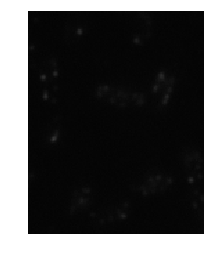

In [64]:
%matplotlib inline
im_plt = io.imshow(c, cmap="gray")
im_plt.axes.axis("off")

## Threshold segmentation

In [49]:
a_thresh = filters.threshold_otsu(a)
a_bin = a > a_thresh

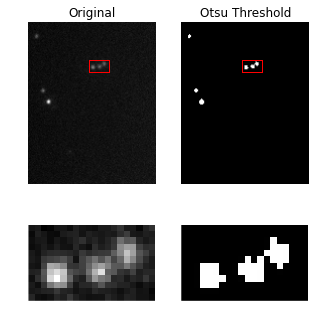

In [50]:
fig_seg_plt, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
ax0.set_title("Original")
ax0.imshow(a, cmap=plt.cm.gray)
ax0.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax1.set_title("Otsu Threshold")
ax1.imshow(a_bin, cmap=plt.cm.gray)
ax1.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))

ax2.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax3.imshow(a_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")

for ax in fig_seg_plt.axes:
    ax.set_axis_off()

fig_seg_plt.set_size_inches(4.4, 5)
plt.tight_layout()

## Gaussian Filter

In [51]:
a_g1 = filters.gaussian_filter(a, sigma=1)
a_g15 = filters.gaussian_filter(a, sigma=1.5)
a_g2 = filters.gaussian_filter(a, sigma=2)
a_g5 = filters.gaussian_filter(a, sigma=5)

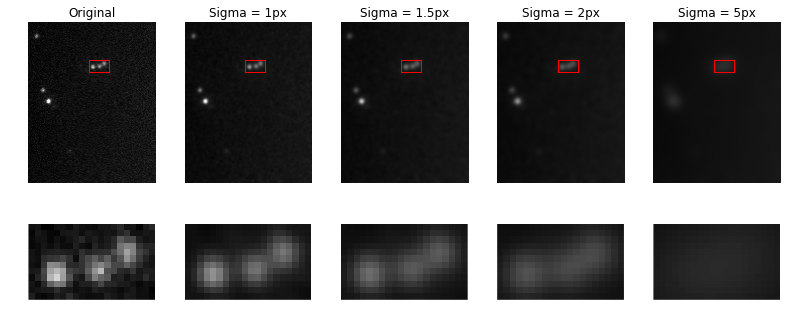

In [52]:
img_gfilt_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.axis("off")
ax0.imshow(a, cmap="gray", vmin=0.010, vmax=0.07)
ax0.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax1.set_title("Sigma = 1px")
ax1.axis("off")
ax1.imshow(a_g1, cmap="gray", vmin=0.010, vmax=0.07)
ax1.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1.5px")
ax2.axis("off")
ax2.imshow(a_g15, cmap="gray", vmin=0.010, vmax=0.07)
ax2.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax3.set_title("Sigma = 2px")
ax3.axis("off")
ax3.imshow(a_g2, cmap="gray", vmin=0.010, vmax=0.07)
ax3.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax4.set_title("Sigma = 5px")
ax4.axis("off")
ax4.imshow(a_g5, cmap="gray", vmin=0.010, vmax=0.07)
ax4.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax5.axis("off")
ax5.imshow(a[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax6.axis("off")
ax6.imshow(a_g1[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax7.axis("off")
ax7.imshow(a_g15[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax8.axis("off")
ax8.imshow(a_g2[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax9.axis("off")
ax9.imshow(a_g5[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)

img_gfilt_plt.set_size_inches(11, 5)
img_gfilt_plt.tight_layout()
# img_gfilt_plt.savefig("assets/images/bama_gfilt_plt.png", dpi=150, transparent=True, bbox_inches="tight")

## Median Filter

In [54]:
a_m1 = img_as_float(filters.median(a, disk(1)))
a_m15 = img_as_float(filters.median(a, disk(1.5)))
a_m2 = img_as_float(filters.median(a, disk(2)))
a_m5 = img_as_float(filters.median(a, disk(5)))

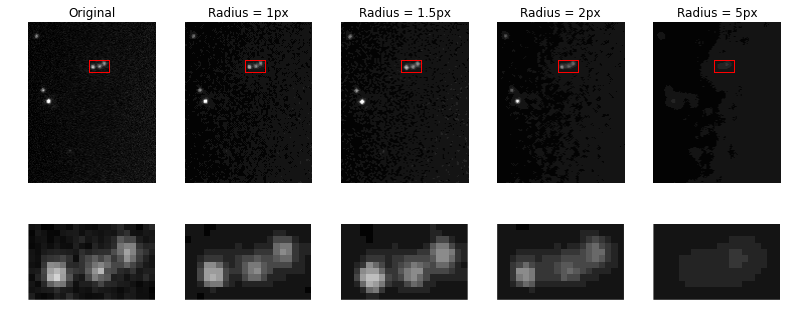

In [55]:
img_mfilt_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.axis("off")
ax0.imshow(a, cmap="gray", vmin=0.011, vmax=0.07)
ax0.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax1.set_title("Radius = 1px")
ax1.axis("off")
ax1.imshow(a_m1, cmap="gray", vmin=0.011, vmax=0.07)
ax1.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax2.set_title("Radius = 1.5px")
ax2.axis("off")
ax2.imshow(a_m15, cmap="gray", vmin=0.011, vmax=0.07)
ax2.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax3.set_title("Radius = 2px")
ax3.axis("off")
ax3.imshow(a_m2, cmap="gray", vmin=0.011, vmax=0.07)
ax3.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax4.set_title("Radius = 5px")
ax4.axis("off")
ax4.imshow(a_m5, cmap="gray", vmin=0.011, vmax=0.07)
ax4.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax5.axis("off")
ax5.imshow(a[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax6.axis("off")
ax6.imshow(a_m1[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax7.axis("off")
ax7.imshow(a_m15[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax8.axis("off")
ax8.imshow(a_m2[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
ax9.axis("off")
ax9.imshow(img_m5[38:50,60:80], cmap="gray", interpolation="none", vmin=0.011, vmax=0.07)
img_mfilt_plt.set_size_inches(11, 5)
img_mfilt_plt.tight_layout()
# img_mfilt_plt.savefig("assets/images/bama_mfilt_plt.png", dpi=150, transparent=True, bbox_inches="tight")

## Difference of Gaussian

In [56]:
a_g1 = filters.gaussian_filter(a, sigma=1)
a_g16 = filters.gaussian_filter(a, sigma=1.6)
a_dog = np.subtract(a_g1, a_g16)

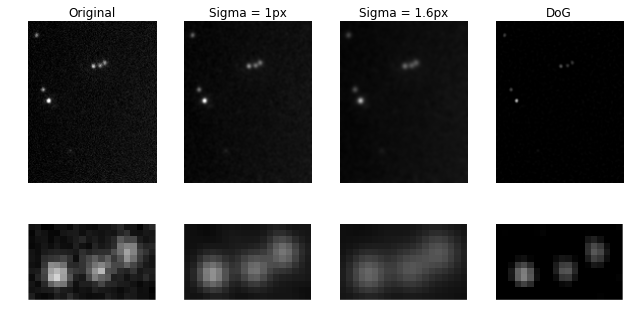

In [57]:
img_dog_plt, ((ax0, ax1, ax2, ax3), (ax5, ax6, ax7, ax8)) = plt.subplots(ncols=4, nrows=2)
ax0.set_title("Original")
ax0.imshow(a, cmap="gray", vmin=0.011, vmax=0.07)
ax1.set_title("Sigma = 1px")
ax1.imshow(a_g1, cmap="gray", vmin=0.011, vmax=0.07)
ax2.set_title("Sigma = 1.6px")
ax2.imshow(a_g16, cmap="gray", vmin=0.011, vmax=0.07)
ax3.set_title("DoG")
ax3.imshow(a_dog, cmap="gray", vmin=0, vmax=0.03)

ax5.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0.011, vmax=0.07)
ax6.imshow(a_g1[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0.011, vmax=0.07)
ax7.imshow(a_g16[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0.011, vmax=0.07)
ax8.imshow(a_dog[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0, vmax=0.02)

for ax in img_dog_plt.axes:
    ax.set_axis_off()

img_dog_plt.set_size_inches(8.8, 5)
plt.tight_layout()

## Watershed

In [58]:
a_dist = ndi.distance_transform_edt(a_bin)
a_peaks = peak_local_max(a_dist, min_distance=4, labels=a_bin,
                           indices=False)
a_markers = ndi.label(a_peaks)[0]
a_labels = watershed(-a, a_markers, mask=a_bin)
a_labels_props = regionprops(a_labels, intensity_image=a)

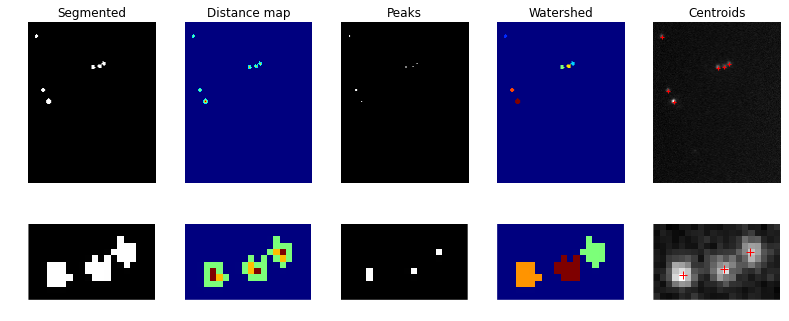

In [59]:
img_seg_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Segmented")
ax0.imshow(a_bin, cmap=plt.cm.gray)
ax1.set_title("Distance map")
ax1.imshow(a_dist, cmap=plt.cm.jet)
ax2.set_title("Peaks")
ax2.imshow(a_peaks, cmap=plt.cm.gray)
ax3.set_title("Watershed")
ax3.imshow(a_labels, cmap=plt.cm.jet)
ax4.set_title("Centroids")
for r in a_labels_props:
    ax4.scatter(r.centroid[1], r.centroid[0], c="r", marker="+")
ax4.imshow(a, cmap='gray')

ax5.imshow(a_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax6.imshow(a_dist[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.jet, interpolation="none")
ax7.imshow(a_peaks[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax8.imshow(a_labels[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.jet, interpolation="none")
for r in a_labels_props[1:4]:
    ax9.scatter(r.centroid[1]-a_zox, r.centroid[0]-a_zoy, c="r", marker="+", s=50)
ax9.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap='gray', interpolation="none")
    
for ax in img_seg_plt.axes:
    ax.axis("off")
img_seg_plt.set_size_inches(11, 5)
img_seg_plt.tight_layout()
# img_seg_plt.savefig("assets/images/img_seg_plt.png", dpi=150,transparent=True, bbox_inches="tight")

## Difference of Gaussian

In [60]:
dog = blob_dog(a, max_sigma=2, threshold=0.0015)

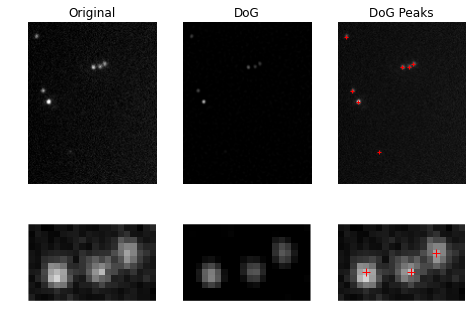

In [61]:
img_dogpeak_plt, ((ax0, ax3, ax4), (ax5, ax8, ax9)) = plt.subplots(ncols=3, nrows=2)
ax0.set_title("Original")
ax0.imshow(a, cmap="gray", vmin=0.011, vmax=0.07)
ax3.set_title("DoG")
ax3.imshow(a_dog, cmap="gray", vmin=0, vmax=0.03)
ax4.set_title("DoG Peaks")
ax4.scatter(x=dog[:,1], y=dog[:,0], c="r", marker=u'+')
ax4.imshow(a, cmap="gray")

ax5.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0.011, vmax=0.07)
ax8.imshow(a_dog[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0, vmax=0.02)
ax9.scatter(dog[1:4,1]-a_zox, dog[1:4,0]-a_zoy, c="r", marker="+", s=50)
ax9.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap='gray', interpolation="none", vmin=0.011, vmax=0.07)


for ax in img_dogpeak_plt.axes:
    ax.set_axis_off()

img_dogpeak_plt.set_size_inches(6.6, 5)
plt.tight_layout()
# img_dogpeak_plt.savefig("assets/images/img_dogpeak_plt.png", dpi=150, transparent=True)

In [ ]:
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r)) in zip(enumerate(axs), dog):
    c_img = img[y-3:y+4,x-3:x+4]
    params = fitgaussian(c_img, (1, 3, 3, 1.6, 1.6))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(img), vmax=np.max(img))
    ax.scatter(x=3, y=3, c="r", marker=u'+', s=50)

fits.set_size_inches(10, 2)
fits.tight_layout()
fits.savefig("assets/images/subpix_spots.png", dpi=150, transparent=True)

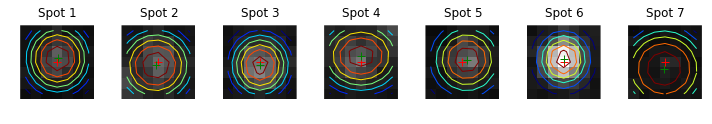

In [26]:
# Radius of 3
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r)) in zip(enumerate(axs), dog):
    c_img = img[y-3:y+4,x-3:x+4]
    params = fitgaussian(c_img, (1, 3, 3, 1.6, 1.6))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(img), vmax=np.max(img))
    ax.scatter(x=3, y=3, c="r", marker=u'+', s=50)
    ax.scatter(x=params[2], y=params[1], c="g", marker=u"+", s=50)
    ax.contour(gaus(*np.indices((7,7))))

fits.set_size_inches(10, 2)
fits.tight_layout()
fits.savefig("assets/images/subpix_fits.png", dpi=150, transparent=True)

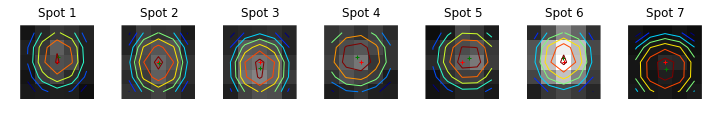

In [27]:
# Radius of 2
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r)) in zip(enumerate(axs), dog):
    c_img = img[y-2:y+3,x-2:x+3]
    params = fitgaussian(c_img, (1, 2, 2, 1.6, 1.6))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(img), vmax=np.max(img))
    ax.scatter(x=2, y=2, c="r", marker=u'+')
    ax.scatter(x=params[2], y=params[1], c="g", marker=u"+")
    ax.contour(gaus(*np.indices((5,5))))

fits.set_size_inches(10, 2)
fits.tight_layout()

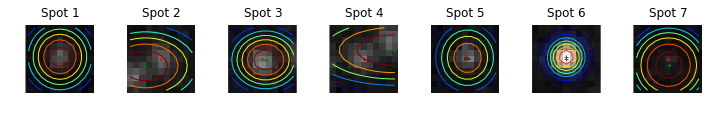

In [28]:
# Radius of 5
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r)) in zip(enumerate(axs), dog):
    c_img = img[y-5:y+6,x-5:x+6]
    params = fitgaussian(c_img, (1, 5, 5, 1.6, 1.6))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(img), vmax=np.max(img))
    ax.scatter(x=5, y=5, c="r", marker=u'+')
    ax.scatter(x=params[2], y=params[1], c="g", marker=u"+")
    ax.contour(gaus(*np.indices((11,11))))

fits.set_size_inches(10, 2)
fits.tight_layout()

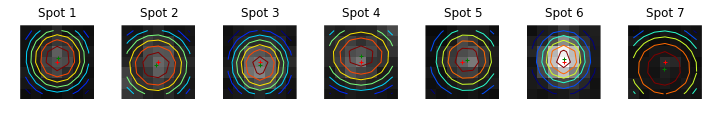

In [29]:
# Estimated Gaussian width of 3
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r)) in zip(enumerate(axs), dog):
    c_img = img[y-3:y+4,x-3:x+4]
    params = fitgaussian(c_img, (1, 3, 3, 3, 3))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(img), vmax=np.max(img))
    ax.scatter(x=3, y=3, c="r", marker=u'+')
    ax.scatter(x=params[2], y=params[1], c="g", marker=u"+")
    ax.contour(gaus(*np.indices((7,7))))

fits.set_size_inches(10, 2)
fits.tight_layout()